# 2.5 - OT PMD An Optimal Transportation-Based User Distance for Recommender Systems


The goal of this notebook is to implement [this paper](hhttps://jmlr.org/papers/volume20/18-700/18-700.pdf), listed as paper 1 in our summary, with a toy dataset.

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_datasets as tfds
from scipy import optimize
from scipy.sparse import random

# Movie similarities

In [ ]:
ratings_original = tfds.as_dataframe(tfds.load('movielens/latest-small-ratings',split='train'))
tag_original = tfds.as_dataframe(tfds.load('movielens/latest-small-movies',split='train'))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/movielens/latest-small-ratings/0.1.0.incompleteSBDTR6/movielens-train.tfrecord


  0%|          | 0/100836 [00:00<?, ? examples/s]

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/latest-small-ratings/0.1.0. Subsequent calls will reuse this data.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/movielens/latest-small-movies/0.1.0.incompleteRCHK09/movielens-train.tfrecord


  0%|          | 0/9742 [00:00<?, ? examples/s]

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/latest-small-movies/0.1.0. Subsequent calls will reuse this data.


In [ ]:
# Get a matrix of ones and zeros

def get_matrixes (df_in):

  # Keeping ratings 

  df_r = df_in[['movie_id','user_id','user_rating']]\
    .pivot(index='user_id', columns='movie_id',values='user_rating')

  # Marking if seen (null~zero)

  df_s = df_r.fillna(0)
  df_s.mask(df_s != 0,1,inplace=True)

  # Setting types

  df_r = df_r.astype(pd.SparseDtype("float", np.nan)) 
  df_s = df_s.astype(pd.SparseDtype("int", 0)) 

  return df_r, df_s
  
rating, seen = get_matrixes(ratings_original)

In [ ]:
tag_matched = tag_original.set_index('movie_id').loc[list(seen.columns)]

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

mlb = MultiLabelBinarizer()
tag_one_hot  = mlb.fit_transform(tag_matched['movie_genres'])

In [ ]:
tag_one_hot.shape

(9724, 20)

In [ ]:
cosine_sim = cosine_distances(tag_one_hot)
cosine_sim.shape

(9724, 9724)

# Distance between users

In [ ]:
!pip install POT
import ot

     |████████████████████████████████| 430 kB 5.4 MB/s 


In [ ]:
tag_df = pd.DataFrame(tag_one_hot,index=tag_matched.index)
users = np.array(seen.index)

def movies_seen_by_genre (seen,user):
  u = seen.loc[user]
  seen_by_u = u[u == 1]
  out = tag_df.loc[seen_by_u.index].sum().astype('int')
  out.index = out.index.astype('int')
  return out

def get_comparative_hist(seen,u1,u2,title):

  u1_by_genre = movies_seen_by_genre(seen,u1)
  u2_by_genre = movies_seen_by_genre(seen,u2)

  plt.hist(u1_by_genre.values,u1_by_genre.index,color='r',alpha = 0.5,label=f'{u1}')
  plt.hist(u2_by_genre.values,u2_by_genre.index,color='b',alpha = 0.5,label=f'{u2}')
  
  plt.legend()
  plt.title(title)
  plt.show()

def user_distance(seen,u1,u2,gamma,epsilon):
  a = np.array(seen.loc[u1]/seen.loc[u1].sum()) + epsilon
  b = np.array(seen.loc[u2]/seen.loc[u2].sum()) + epsilon
  M = cosine_sim + epsilon
  P = ot.sinkhorn(a, b, M, gamma, verbose=True)
  d = np.sum(np.multiply(P,cosine_sim))
  print(d)
  return d

In [ ]:
u1 = seen.index[0]
u2 = seen.index[1]

d1 = user_distance(seen,u1,u2,0.15,10**-15)

It.  |Err         
-------------------
    0|7.241036e-02|
   10|2.842932e-05|
   20|7.846471e-09|
   30|2.165331e-12|
0.49081534429967494


In [ ]:
u3 = seen.index[2]
u4 = seen.index[3]

d2 = user_distance(seen,u3,u4,0.15,10**-15)

It.  |Err         
-------------------
    0|8.549831e-02|
   10|1.090229e-04|
   20|6.637479e-07|
   30|4.313935e-09|
   40|2.806829e-11|
0.36937684268738097


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

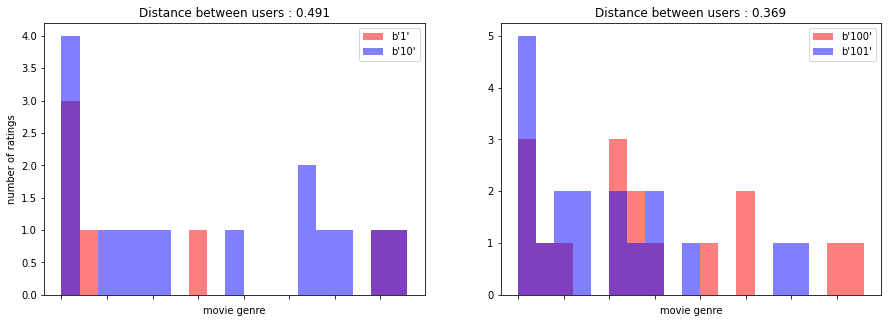

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (15,5))

u1_by_genre = movies_seen_by_genre(seen,u1)
u2_by_genre = movies_seen_by_genre(seen,u2)

ax1.hist(u1_by_genre.values,u1_by_genre.index,color='r',alpha = 0.5,label=f'{u1}')
ax1.hist(u2_by_genre.values,u2_by_genre.index,color='b',alpha = 0.5,label=f'{u2}')
ax1.legend()
ax1.set_title(f'Distance between users : {round(d1,3)}')
ax1.set_xlabel('movie genre')
ax1.set_ylabel('number of ratings')
ax1.set_xticklabels([])

u3_by_genre = movies_seen_by_genre(seen,u3)
u4_by_genre = movies_seen_by_genre(seen,u4)

ax2.hist(u3_by_genre.values,u3_by_genre.index,color='r',alpha = 0.5,label=f'{u3}')
ax2.hist(u4_by_genre.values,u4_by_genre.index,color='b',alpha = 0.5,label=f'{u4}')
ax2.legend()
ax2.set_title(f'Distance between users : {round(d2,3)}')
ax2.set_xticklabels([])
ax2.set_xlabel('movie genre')

fig.show()

from google.colab import files
fig.savefig('pmd_distance.jpg')
files.download('pmd_distance.jpg')